In [2080]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from wordcloud import WordCloud
from textblob import TextBlob
import datetime
import time
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import table 
import plotly.express as px
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('brown')

In [2038]:
# set settings
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
2
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.max_colwidth', 150)

In [2039]:
# read in csv files
rc = pd.read_csv("simplyrecipes.csv")
ct = pd.read_csv("../category/simplycategory.csv")

In [2040]:
# ct file: clean up
ct['type'] = ct.category.apply(lambda x: x.split('/')[1])
ct_order = ['author', 'dish', 'type']
ct = ct[ct_order]

In [2041]:
# rc file: missing values
# if dish is missing, discard data
rc.dropna(subset=['dish'], inplace=True)
# drop column with no ingredients
rc.dropna(subset=['ingredients'], inplace=True)
# if cook time missing, discard data
#rc = rc[rc[['time_cook', 'time_prep']].notna().any(axis = 1)]
rc.dropna(subset=['time_cook'], inplace=True)
rc.dropna(subset=['time_prep'], inplace=True)
# drop num_comment column, all NaN
rc = rc.drop(columns = ['num_comment', 'time_other_type','time_other', 'time_other_full'])
# drop no tag rows
rc.dropna(subset = ['tags'], inplace = True)

In [2042]:
# rc file: split cell content string to list
lst1 = ['time_cook', 'time_prep', 'tags']
rc[lst1] = rc[lst1].apply(lambda x: x.str.split(','))

In [2043]:
# rc file: change rating star to numbers
rc.rating_star.unique() # only 5 starts
rc['rating_star'] = rc.rating_star.str.replace('yyyyy', '5')

In [2044]:
# rc file: clean ingredients with regex
# lower case all letters
rc['inglst'] = rc.ingredients.str.lower()
# get rid of number & punctuation 
rc['inglst'] = rc.inglst.apply(lambda x: re.sub('\W', " ", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub('\d', " ", x))

In [2045]:
# rc file: remove common seasoning
lst4 = ["olive oil", "sea salt", "black pepper"]
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("olive oil", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("sea salt", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("black pepper", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("soy sauce", "", x))

In [2046]:
# rc file: tokenize ingredients
def safe_word_tokenize(x):
    try:
        return word_tokenize(x)
    except:
        return 'empty'
#rc['inglst'] = rc.ingredients.apply(safe_word_tokenize)
rc['inglst'] = rc.inglst.apply(word_tokenize)

In [2047]:
# rc file: customize stop words list
lst2 = ['pinch','approx','inch','inches','cups','cup','ml','tablespoons','tablespoon','tbsp', 'teaspoon','teaspoons','kg','g','grams','gram','lbs','lb','pound','pounds','ounce','ounces','oz']
lst3 = ['extra','mignon','ends','end','dinosaur','brown','center','head','paste','fresh','chopped','fat','dijon','part','package','use','plain','chef','cold','brand','section','combination','garnish','serve','servings','quart','serving','note','firm','room','temperature','tube','seasoning','length','lengths','quality','knife','kind','chunk','chunks','cubes','store','virgin','flakes','flake','slices','ground','piece','pieces','sprig','sprigs','medium','thick','cut','bunch','half', 'strips','kosher','stock','powder','taste','cube','handful','handfuls','cans','wedge','wedges','leaves']
lst4 = ['salt','oil','water','sugar','vinegar','cream','dill','worcestershire','sauce','ketchup','mustard','seed','seeds','rosemary','sage','ghee','nutmeg','mirin','sodium','sesame','bay','leaf','cumin','oregano','mint','clove','cloves','parsley','cilantro','basil','scallion','thyme','garlic','butter','canola','ginger']
stopIng = stopwords.words('english')
stopIng.extend(lst2)
stopIng.extend(lst3)
stopIng.extend(lst4)
#print(stopIng)
'cans' in stopIng

True

In [2048]:
# rc file: exlude stop words from inglst
rc['inglst'] = rc.inglst.apply(lambda x: [el for el in x if el not in stopIng])

In [2049]:
# rc file: only keep nouns in inglst
rc['inglst'] = rc.inglst.apply(nltk.pos_tag)
def only_noun(lst):
    nouns = [word for (word, pos) in lst if pos[:2]=="NN"]
    return nouns
rc['inglst'] = rc.inglst.apply(only_noun)

In [2050]:
# rc file: parse time
def unify_time(lst):
    time = dict()
    for item in lst:
        item = item.lstrip()
        if 'hour' in item:
            hour = int(re.sub('\D', '', item))
            time.update({'hour':hour})

        if 'minute' in item:
            minute = int(re.sub('\D', '', item))
            time.update({'minute':minute})

    duration = time.get('hour', 0)*60 + time.get('minute', 0)
    return duration
rc['time_cook'] = rc.time_cook.apply(unify_time)
rc['time_prep'] = rc.time_prep.apply(unify_time)

In [2051]:
# rc file: column reorder
rc_order = ['author', 'dish', 'inglst', 'time_prep', 'time_cook', 'tags', 'ingredients','servings', 'rating_star', 'rating_num', 'meta_description']
rc = rc[rc_order]

In [2052]:
# rc file: parse tag
rc['tags'] = rc.tags.apply(lambda x: [el.lower() for el in x ])

In [2053]:
# df file: merge rc-recipe & ct-category files
df = pd.merge(ct, rc, on = ['author', 'dish'], how = 'right')
df.type.fillna('other', inplace=True)
#df.to_csv('simply_recipe_datasheet.csv', header = True)
# melt cook & prep time into 1 column
df_time = df.copy()
df_time = pd.melt(df_time, id_vars=['dish', 'type'], value_vars=['time_cook', 'time_prep']).sort_values('dish',ascending=False)
df_time.rename(columns={'value': 'time_minute', 'variable': 'step'}, inplace=True)

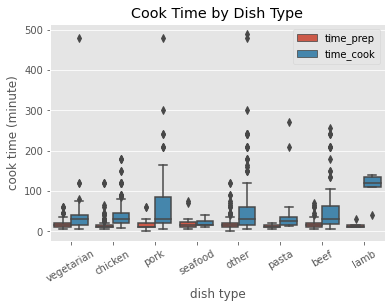

In [2064]:
# df: cook time analysis
df['time_cook'].describe()
# boxplot
#df.boxplot(by='type', column = 'time_cook') #.set_title('cook time by dish type')
#df_time.boxplot(by = 'type', column = 'time_minute')
fig = sns.boxplot(x="type", y='time_minute', data = df_time, hue = 'step')
# plot settings
plt.xlabel('dish type')
plt.ylabel('cook time (minute)')
plt.title('Cook Time by Dish Type')
plt.suptitle("")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt_tcook_box.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
fig.legend(loc='upper right')
plt.setp(fig.get_xticklabels(),rotation = 30)
plt.savefig('fig',dpi = 400)

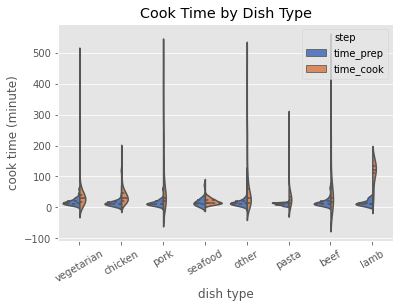

In [2065]:
# violin plot
fig = sns.violinplot(x='type', y='time_minute', hue = 'step', data = df_time, palette='muted', split = True, inner="quartile")
# plot settings
plt.xlabel('dish type')
plt.ylabel('cook time (minute)')
plt.title('Cook Time by Dish Type')
plt.suptitle("")

#plt.legend(title = 'Step', loc="upper right", labels = ['prep', 'cook'])
plt.setp(fig.get_xticklabels(),rotation = 30)
plt.savefig('fig',dpi = 400)

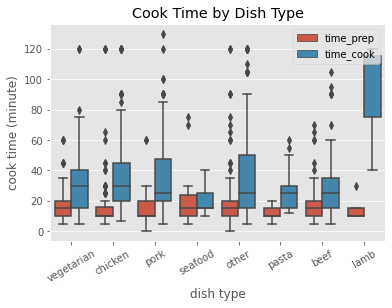

In [2066]:
# cook & prep time with less extreme
#scatter_df = scatter_df.loc[scatter_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
df[['dish', 'type', 'time_cook', 'time_prep']].groupby(type)[['time_cook', 'time_prep']].describe()
df_time_center = df_time[df_time['time_minute'].apply(lambda x: np.abs(x-df_time.time_minute.mean())/df_time.time_minute.std() < 2)] # 95% of data

fig = sns.boxplot(x="type", y='time_minute', data = df_time_center, hue = 'step')
# plot settings
plt.xlabel('dish type')
plt.ylabel('cook time (minute)')
plt.title('Cook Time by Dish Type')
plt.suptitle("")
fig.legend(loc='upper right')
plt.setp(fig.get_xticklabels(),rotation = 30)
plt.savefig('plot_time_center_boxplot',dpi = 400)

In [1947]:
# correlation with time & type
corr_time_table = df.corr()
corr_time = round(df.time_cook.corr(df.time_prep),4)
print(corr_time_table)
corr_time_table.to_csv("corr_table_time.csv")

model_cook = ols('time_cook~C(type)', data = df).fit()
anova_table_cook = sm.stats.anova_lm(model, typ=2)
model_prep = ols('time_prep~C(type)', data = df).fit()
anova_table_prep = sm.stats.anova_lm(model, type=2)
anova_table_cook.to_csv('anova_table_cook.csv')
anova_table_prep.to_csv('anova_table_prep.csv')

            time_prep  time_cook  rating_num
time_prep    1.000000   0.038439   -0.017579
time_cook    0.038439   1.000000    0.088395
rating_num  -0.017579   0.088395    1.000000


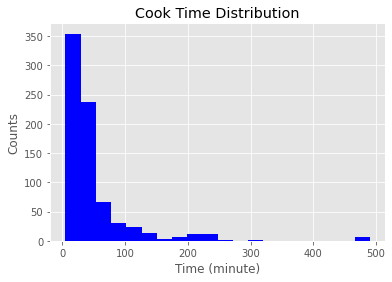

In [1942]:
# plot cook time
plt.hist(rc['time_cook'], bins = 20, color="blue")
plt.xlabel('Time (minute)')
plt.ylabel('Counts')
plt.title('Cook Time Distribution')
plt.savefig('plot_time_cook_histogram', dpi=400)

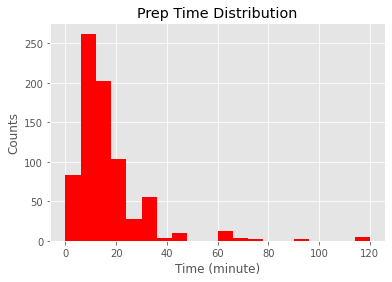

In [1943]:
# plot prep time
plt.hist(rc['time_prep'], bins=20, color="red")
plt.xlabel('Time (minute)')
plt.ylabel('Counts')
plt.title('Prep Time Distribution')
plt.savefig('plot_time_prep_histogram', dpi=400)

In [1964]:
# plotly histogram
# by type
#fig = px.histogram(df, x='time_cook', color = 'type')
df_time['time_minute'].describe()

count    1542.000000
mean       33.185473
std        48.836342
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       490.000000
Name: time_minute, dtype: float64

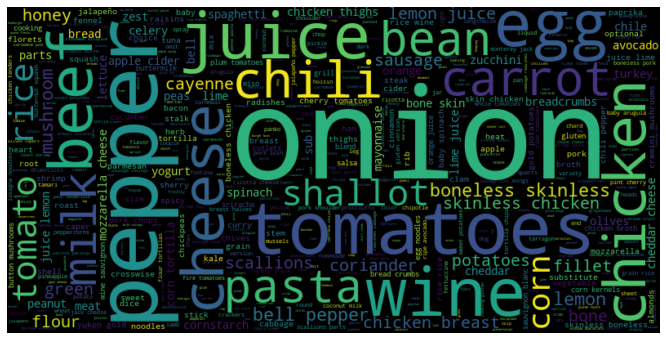

<Figure size 432x288 with 0 Axes>

In [1959]:
# df: ingredient lists word cloud - all
inglst_values = df.inglst.values
inglst_values.tolist()
alling = [item for sublist in inglst_values for item in sublist]

# word cloud of inglst
wc = WordCloud(background_color="black", max_words=2000, width=800, height=400)
#wc.generate(' '.join(rc['inglst'][0]))
wc.generate(' '.join(alling))
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('wc_ingredient',dpi = 400)

In [2084]:
#sent = 'This is an example sentence'
# fdist = FreqDist()
# for word in word_tokenize(sent):
#     fdist[word.lower()] += 1
#fdist = FreqDist(word.lower() for word in word_tokenize(sent))
FreqDist(word for word in alling)

FreqDist({'onion': 396, 'chicken': 265, 'juice': 214, 'pepper': 204, 'tomatoes': 199, 'cheese': 154, 'wine': 137, 'rice': 114, 'onions': 112, 'lemon': 107, ...})

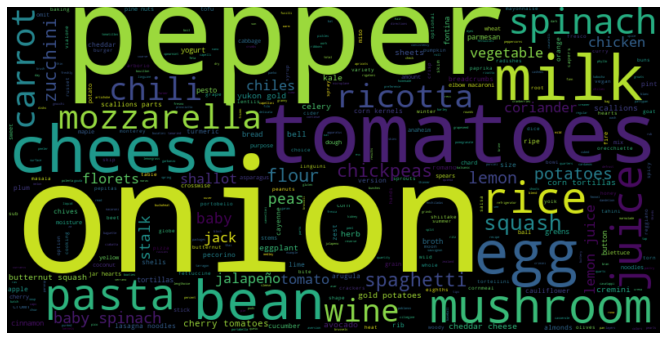

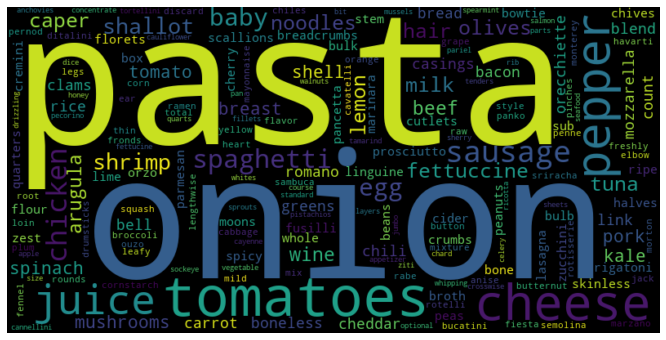

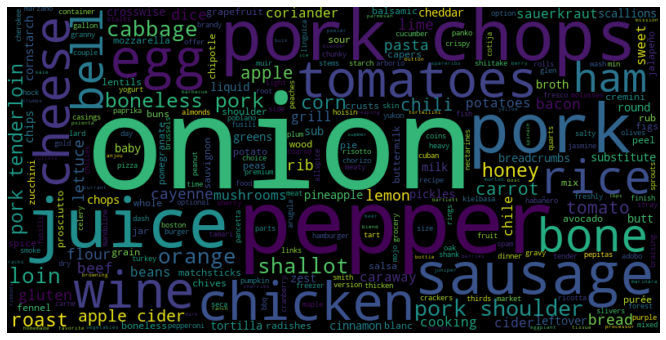

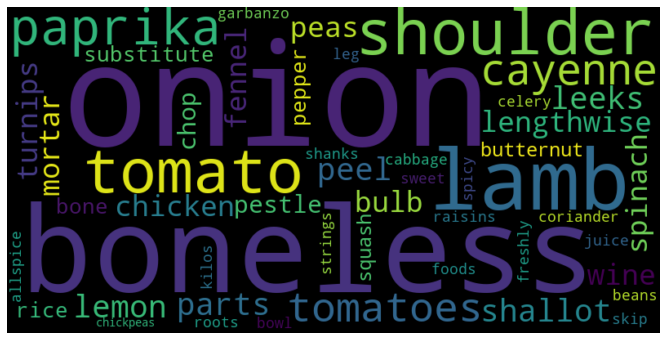

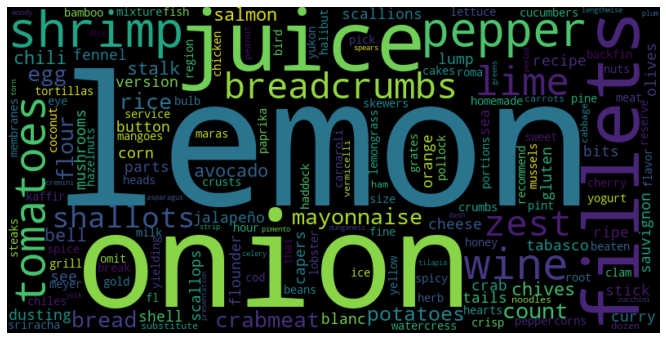

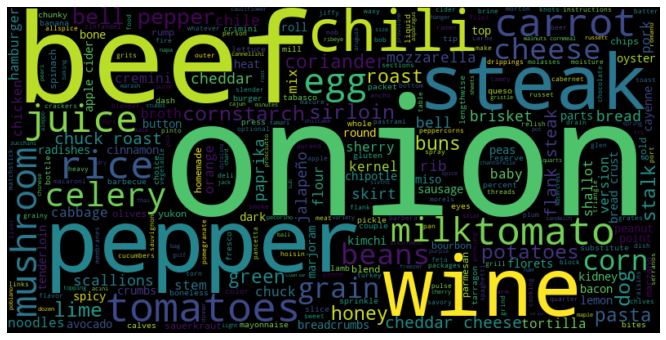

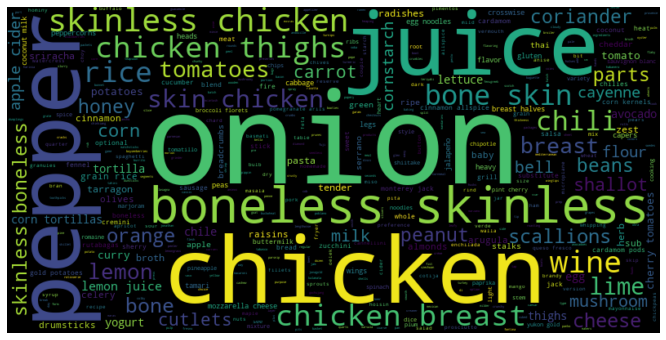

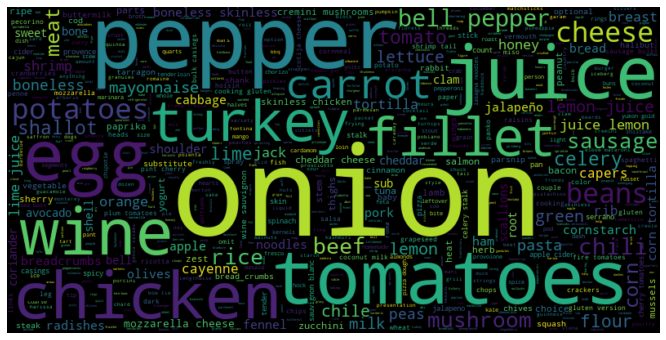

In [2073]:
# word cloud of ingredients by type
# df: ingredient lists word cloud
#df.groupby('type')['inglst']values
inglst_bytype = df.groupby('type').inglst.apply(list)
#df.groupby('type').inglst.apply(lambda s: s.values)
inglst_bytype = inglst_bytype.apply(lambda x: [item for sublist in x for item in sublist])

types = df.type.unique().tolist()
for type in types:
    # word cloud of inglst by type
    wc = WordCloud(background_color="black", max_words=2000, width=800, height=400)
    wc.generate(' '.join(inglst_bytype[type]))
    # show
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    #plt.show()
    plt_name = 'plot_wordcloud_'+ type
    plt.savefig(plt_name,dpi = 400)

In [2079]:
# word cloud of ingredients by cook time
df.inglst.apply(len).describe()

count    771.000000
mean      11.678340
std        4.870029
min        1.000000
25%        8.000000
50%       11.000000
75%       15.000000
max       31.000000
Name: inglst, dtype: float64

In [1503]:
# take the last 2 words of ing
#rc['ing'] = rc.ingredients.apply(lambda x: re.sub('\(.*\)', '', x))
#rc.ing
#rc.ing.apply(lambda x: [el for el in x.split() if el not in stopIng])

In [1018]:
# food = wordnet.synset('food.n.02')
# for i in food.closure(lambda s:s.hyponyms()):
#     print(i)

In [551]:
# test why wordtokenize did not work on column ingredients
# def safe_word_tokenize( x ):
#     try:
#         return word_tokenize( x )
#     except Exception as e:
#         print( f"Error with {x}. Exception given: {e}" )
#         print( "-"*25 + "\n" )
# rc.ingredients.apply(safe_word_tokenize)

In [352]:
# extract time
#rc['time_cook'].apply(lambda x: x.split(','))
# rc['time_cook'] = rc['time_cook'].str.split(',')
# rc['time_prep'] = rc['time_prep'].str.split(',')
# rc['ingredients'] = rc.ingredients.str.split(',')
# rc['tags'] = rc.tags.str.split(',')
#rc.rating_star.str.replace('yyyyy', 5)
#rc.rating_star.str.replace('yyyyy', '5')

In [1259]:
# old wrong codes
#rc['inglst'].apply(lambda x: x if x not in stopIng else '')
#rc.inglist.apply(lambda x: re.sub(lambda y: y, lst4), "", x)

In [ ]:
# need work code
# def remove_season(lst,x):
#     for item in lst:
#         re.sub(item, "", x)
# rc.inglst.apply(remove_season, lst4)
# blob = TextBlob(" ".join(rc.inglst.iloc[1]))
# print(blob.noun_phrases)

In [ ]:
#df = pd.read_csv('https://s3.amazonaws.com/nycdsabt01/movie_metadata.csv')

In [ ]:
# IDEAS
#rc.ingredients.sample(5)
# only take the last two words of each , separated words in ingredients
#rc.sample(5)

In [ ]:
# reference code
#rc.inglst.apply( lambda x: [el for el in x if (el not in stopIng)] )

# lines = 'lines is some string of words'
# tokenized = nltk.word_tokenize(lines)
# nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')]
# nouns = [(word, pos) for (word, pos) in nltk.pos_tag(tokenized)]
# nltk.pos_tag(tokenized)

In [ ]:
# parse tags
# test = rc.tags.apply(lambda x: [el for el in x if el == 'beef'])
# def sort_tag(lst):
#     for tag in lst:
#         switch(tag:
#                beef = 'beef', chicken = 'chicken', vege = 'vegetarian', seafood = 'fish and seafood', pork = pork)
#     return main
# rc.tags.apply(sort_tag)
#rc.inglst.apply( lambda x: [el for el in x if (el not in stopIng)] )